<a href="https://colab.research.google.com/github/corrine1106/Project_EDA/blob/master/Churns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
from datetime import datetime,timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb

In [144]:
#amount = 金額
course = pd.read_csv('/content/drive/MyDrive/T大使/dataset/Course product consumption amount.csv')
consumption = pd.read_csv('/content/drive/MyDrive/T大使/dataset/Number of consumption.csv')
physical = pd.read_csv('/content/drive/MyDrive/T大使/dataset/Number of physical exercise classes.csv')
# 回店次數
visit = pd.read_csv('/content/drive/MyDrive/T大使/dataset/Number of visits.csv')
# 剩餘堂數
remain = pd.read_csv('/content/drive/MyDrive/T大使/dataset/Remaining number of classes.csv')
# 轉店次數
transfer = pd.read_csv('/content/drive/MyDrive/T大使/dataset/Transfer store.csv')
# 客訴
complain = pd.read_csv('/content/drive/MyDrive/T大使/dataset/complain+call customer.csv')

In [145]:
complain

,member_code,member,complaints_cnt,CALL_cnt
0,9100000013183,詹閔淳,0,9
1,9100000023069,張丹,0,2
2,9100000587721,辛慧君,0,1
3,9100000756653,林姵吟,0,6
4,9100001439708,石文琳,0,14
...,...,...,...,...
191,9100003026883,饒蓉蓉,0,2
192,9100003028047,林育施,0,1
193,9100003034994,劉芳宜,0,1
194,9100003043088,彭慧玲,0,1


# Data Wrangling

In [146]:
course['final_consumption_date'] = pd.to_datetime(course['final_consumption_date']) 

In [147]:
Member_attribute = pd.DataFrame(course['member_code'].unique())
Member_attribute.columns = ['member_code']

In [148]:
Member_attribute = pd.merge(Member_attribute,course,on='member_code',how='left')
Member_attribute = pd.merge(Member_attribute,consumption.drop(columns=['member']),on='member_code',how='left')
Member_attribute = pd.merge(Member_attribute,physical.drop(columns=['member']),on='member_code',how='left')
Member_attribute = pd.merge(Member_attribute,visit.drop(columns=['member']),on='member_code',how='left')
Member_attribute = pd.merge(Member_attribute,remain.drop(columns=['member']),on='member_code',how='left')
Member_attribute = pd.merge(Member_attribute,transfer.drop(columns=['member']),on='member_code',how='left')
Member_attribute = pd.merge(Member_attribute,complain.drop(columns=['member']),on='member_code',how='left')

In [149]:
# 流失的定義：上次回店日超過一年
now = datetime.now()
# now = datetime(2020, 12, 31) 
now = pd.to_datetime(now.strftime('%Y-%m-%d'))

Member_attribute['Churn'] = 0
Member_attribute.loc[(now-Member_attribute['final_consumption_date']).dt.days>365,'Churn'] = 1
Member_attribute

,member_code,member,final_consumption_date,course_amount,product_amount,consumption_num,done_face_count,done_body_count,back_store_cnt,Remaining_face_course,Remaining_body_course,transfer_cnt,complaints_cnt,CALL_cnt,Churn
0,9100000013183,詹閔淳,2021-07-21,13946.0,4524.0,3.0,9.0,3.0,10,6.0,0.0,NaN,0.0,9.0,0
1,9100000021898,潘靜,2021-08-27,9476.0,13580.0,7.0,3.0,6.0,13,0.0,0.0,NaN,NaN,NaN,0
2,9100000023069,張丹,2021-09-02,15479.0,1927.0,10.0,0.0,35.0,18,0.0,0.0,NaN,0.0,2.0,0
3,9100000219776,黃偉婷,2020-11-02,2279.0,19320.0,5.0,3.0,16.0,11,2.0,0.0,NaN,NaN,NaN,1
4,9100000388762,謝怡璇,2019-11-27,7719.0,5864.0,4.0,1.0,9.0,10,0.0,4.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7647,9100003057047,蕭存庭,2021-08-13,3000.0,0.0,1.0,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN,0
7648,9100003057054,吳雅惠,2021-09-06,7440.0,557.0,1.0,0.0,1.0,1,1.0,5.0,NaN,NaN,NaN,0
7649,9100003057177,賴湘昀,2021-02-04,3000.0,0.0,1.0,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN,0
7650,9100003057306,林雅文,2020-12-31,7440.0,557.0,1.0,NaN,NaN,1,1.0,6.0,NaN,NaN,NaN,1


In [150]:
Member_attribute.fillna(0,inplace=True)

Member_attribute

,member_code,member,final_consumption_date,course_amount,product_amount,consumption_num,done_face_count,done_body_count,back_store_cnt,Remaining_face_course,Remaining_body_course,transfer_cnt,complaints_cnt,CALL_cnt,Churn
0,9100000013183,詹閔淳,2021-07-21 00:00:00,13946.0,4524.0,3.0,9.0,3.0,10,6.0,0.0,0.0,0.0,9.0,0
1,9100000021898,潘靜,2021-08-27 00:00:00,9476.0,13580.0,7.0,3.0,6.0,13,0.0,0.0,0.0,0.0,0.0,0
2,9100000023069,張丹,2021-09-02 00:00:00,15479.0,1927.0,10.0,0.0,35.0,18,0.0,0.0,0.0,0.0,2.0,0
3,9100000219776,黃偉婷,2020-11-02 00:00:00,2279.0,19320.0,5.0,3.0,16.0,11,2.0,0.0,0.0,0.0,0.0,1
4,9100000388762,謝怡璇,2019-11-27 00:00:00,7719.0,5864.0,4.0,1.0,9.0,10,0.0,4.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7647,9100003057047,蕭存庭,2021-08-13 00:00:00,3000.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0
7648,9100003057054,吳雅惠,2021-09-06 00:00:00,7440.0,557.0,1.0,0.0,1.0,1,1.0,5.0,0.0,0.0,0.0,0
7649,9100003057177,賴湘昀,2021-02-04 00:00:00,3000.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0
7650,9100003057306,林雅文,2020-12-31 00:00:00,7440.0,557.0,1.0,0.0,0.0,1,1.0,6.0,0.0,0.0,0.0,1


In [151]:
course.loc[course.final_consumption_date.isna()]

,member_code,member,final_consumption_date,course_amount,product_amount
30,9100001485262,蕭美滿,NaT,19280.0,11308.0
84,9100001742785,黃千桂,NaT,9800.0,13160.0
115,9100001905074,李雅惠,NaT,18541.0,20275.0
182,9100002037255,李鈺英,NaT,12069.0,4916.0
250,9100002179931,高可融,NaT,0.0,14780.0
...,...,...,...,...,...
6473,9100002978244,張芸瑜,NaT,7738.0,4233.0
6549,9100002983392,馬惠婷,NaT,10600.0,6358.0
6572,9100002984795,廖佳媁,NaT,7638.0,9032.0
6794,9100002998761,劉佳瑩,NaT,6446.0,6329.0


In [152]:
Member_attribute.isna().any()

member_code               False
member                    False
final_consumption_date    False
course_amount             False
product_amount            False
consumption_num           False
done_face_count           False
done_body_count           False
back_store_cnt            False
Remaining_face_course     False
Remaining_body_course     False
transfer_cnt              False
complaints_cnt            False
CALL_cnt                  False
Churn                     False
dtype: bool

In [153]:
Member_attribute['total_amount'] = Member_attribute['product_amount'] + Member_attribute['course_amount']
Member_attribute['Remian_course'] = Member_attribute['Remaining_face_course'] + Member_attribute['Remaining_body_course']

Member_attribute

,member_code,member,final_consumption_date,course_amount,product_amount,consumption_num,done_face_count,done_body_count,back_store_cnt,Remaining_face_course,Remaining_body_course,transfer_cnt,complaints_cnt,CALL_cnt,Churn,total_amount,Remian_course
0,9100000013183,詹閔淳,2021-07-21 00:00:00,13946.0,4524.0,3.0,9.0,3.0,10,6.0,0.0,0.0,0.0,9.0,0,18470.0,6.0
1,9100000021898,潘靜,2021-08-27 00:00:00,9476.0,13580.0,7.0,3.0,6.0,13,0.0,0.0,0.0,0.0,0.0,0,23056.0,0.0
2,9100000023069,張丹,2021-09-02 00:00:00,15479.0,1927.0,10.0,0.0,35.0,18,0.0,0.0,0.0,0.0,2.0,0,17406.0,0.0
3,9100000219776,黃偉婷,2020-11-02 00:00:00,2279.0,19320.0,5.0,3.0,16.0,11,2.0,0.0,0.0,0.0,0.0,1,21599.0,2.0
4,9100000388762,謝怡璇,2019-11-27 00:00:00,7719.0,5864.0,4.0,1.0,9.0,10,0.0,4.0,0.0,0.0,0.0,1,13583.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7647,9100003057047,蕭存庭,2021-08-13 00:00:00,3000.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0,3000.0,0.0
7648,9100003057054,吳雅惠,2021-09-06 00:00:00,7440.0,557.0,1.0,0.0,1.0,1,1.0,5.0,0.0,0.0,0.0,0,7997.0,6.0
7649,9100003057177,賴湘昀,2021-02-04 00:00:00,3000.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0,3000.0,0.0
7650,9100003057306,林雅文,2020-12-31 00:00:00,7440.0,557.0,1.0,0.0,0.0,1,1.0,6.0,0.0,0.0,0.0,1,7997.0,7.0


In [154]:
Member_attribute['Churn'].value_counts()

1    3891
0    3761
Name: Churn, dtype: int64

In [155]:
Member_attribute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7652 entries, 0 to 7651
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   member_code             7652 non-null   int64  
 1   member                  7652 non-null   object 
 2   final_consumption_date  7652 non-null   object 
 3   course_amount           7652 non-null   float64
 4   product_amount          7652 non-null   float64
 5   consumption_num         7652 non-null   float64
 6   done_face_count         7652 non-null   float64
 7   done_body_count         7652 non-null   float64
 8   back_store_cnt          7652 non-null   int64  
 9   Remaining_face_course   7652 non-null   float64
 10  Remaining_body_course   7652 non-null   float64
 11  transfer_cnt            7652 non-null   float64
 12  complaints_cnt          7652 non-null   float64
 13  CALL_cnt                7652 non-null   float64
 14  Churn                   7652 non-null   

# Training Data

In [156]:
X = Member_attribute.drop(['Churn','member','member_code','final_consumption_date'],axis=1)
y = Member_attribute.Churn

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56)

In [157]:
xgb_model = xgb.XGBClassifier(max_depth=5,learning_rate=0.08,objective='binary:logistic',n_jobs=-1).fit(X_train,y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train,y_train)))
print('Accuracy of XGB classifier on testing set: {:.2f}'.format(xgb_model.score(X_test,y_test)))

Accuracy of XGB classifier on training set: 0.75
Accuracy of XGB classifier on testing set: 0.68


In [158]:
from sklearn.metrics import classification_report
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1105
           1       0.69      0.69      0.69      1191

    accuracy                           0.68      2296
   macro avg       0.68      0.67      0.67      2296
weighted avg       0.68      0.68      0.68      2296



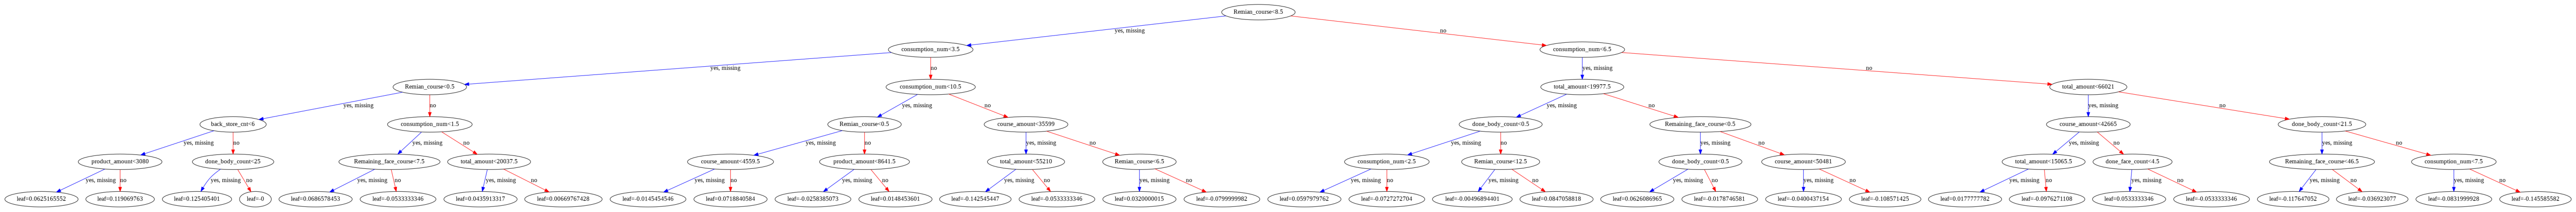

In [159]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(100,100))
plot_tree(xgb_model, ax=ax)

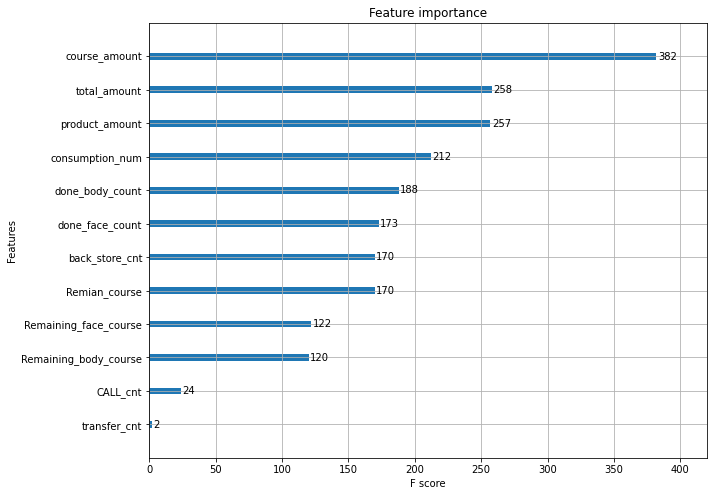

In [160]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)